In [ ]:
# Segmentating one participant EMG data

In [2]:
import EMGfiltersCONFIDENTIAL as EMGfilt
import h5py
from pathlib import Path
import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import welch, iirnotch, filtfilt, butter, lfilter, iirfilter
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from math import ceil, sqrt
import os
import matplotlib.tri as mtri
from scipy.interpolate import griddata
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import cKDTree
from scipy.ndimage import gaussian_filter
import warnings
import seaborn as sns


In [3]:
def open_hdf5_file(file_path, dataset_name, mode='r'):
    hdf5_file = h5py.File(file_path, mode)
    if dataset_name in hdf5_file:
        dataset = hdf5_file[dataset_name]
    else:
        raise ValueError(f"Dataset '{dataset_name}' not found in the file.")
    return hdf5_file, dataset

# --- helper functions ---
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low')
    return b, a

def emg_envelope(signal_1d, fs, lowcut=10, highcut=450, envelopecut=2, order=4):
    """
    signal_1d: 1D numpy array for a single EMG channel
    fs: sampling frequency
    lowcut/highcut: bandpass cutoffs
    envelopecut: low-pass cutoff for envelope (Hz)
    """
    # 1) Bandpass
    b_bp, a_bp = butter_bandpass(lowcut, highcut, fs, order=order)
    emg_bp = filtfilt(b_bp, a_bp, signal_1d)

    # 2) Rectify
    emg_rect = np.abs(emg_bp)

    # 3) Low-pass for envelope
    b_lp, a_lp = butter_lowpass(envelopecut, fs, order=order)
    emg_env = filtfilt(b_lp, a_lp, emg_rect)

    return emg_env, emg_bp

In [10]:
file_path = '/Volumes/LaCie/ResearchProjects/Null_Space_EMG/PT_11/PT_11_Day5/PT_11_5_2025_05_02/Tapes/Raw_emg_4.hdf5'
dataset_name = 'rawEMG'
hdf5_file, dataset = open_hdf5_file(file_path, dataset_name, mode='r')
data = np.array(dataset[:])
print(data.shape)

#no magic numbers
chanNumb = 64  # Number of channels for bipolar setup
fs = 2000  # sampling frequency
lowcut = 10
highcut = 450
lowpass_filt = 450
highpass_filt = 10
envelopecut = 2
emg_filters = EMGfilt.EMGfilters(lowcut, highcut, envelopecut, fs, ch_numb=chanNumb)

# EMG sleeve organizing
order = [25,26,27,28,29,30,31,32,17,18,19,20,21,22,23,24,9,10,11,12,13,14,15,16,1,2,3,4,5,6,7,52,
8,49,50,51,40,39,38,37,36,35,34,33,48,47,46,45,42,43,41,56,47,55,54,53,62,63,64,60,61,57,58,59] #new_order

#new order (PT_16-23)
flexors = [25,26,27,28,29,30,31,32,17,18,19,20,21,22,23,24,9,10] #18 ch # the 8 is renamed to 10 bc sensors have 2 8s
extensors = [11,12,13,14,15,16,1,2,3,4,5,6,7,52,8,49,50,51] #18 ch
bicep = [40,39,38,37,36,35,34,33,48,47,46,45]
lateral_tri = [42,43,41,56,47,55,54,53]
long_tri = [62,63,64,60,61,57,58,59]
# order = [23,24,16,10,9,13,12,11,15,1,14,2,4,3,5,6,7,8,57,60,61,59,62,58,63,64,55,56,54,34,33,41,42,
#          43,44,53,22,21,20,19,18,17,25,26,27,28,29,30,40,32,38,36,31,39,37,35,47,46,45,49,48,52,51,50] #old_order

(120000, 64)


In [78]:
len(bicep)

12

Text(0.5, 1.0, 'Channel 10 @ 60s')

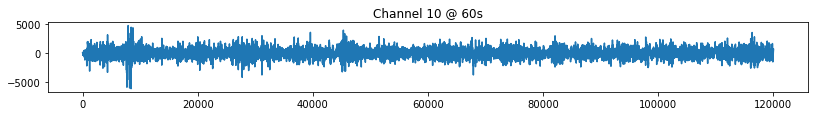

In [70]:
plt.figure(figsize=(128, 12))

ch = flexors[17]
col_idx = order.index(ch)
ax = plt.subplot(8, 8, 1)
ax.plot(data[:120000, col_idx]) #first 2.5 s (5000 samples at 2kHz)
ax.set_title(f"Channel {ch} @ 60s")

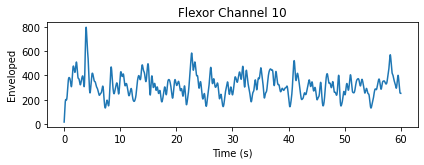

In [71]:
# pick one flexor channel
ch = flexors[17]
col_idx = order.index(ch)

# take first 2.5 s = 5000 samples at 2 kHz
n_samples = int(60 * fs)
raw_sig = data[:n_samples, col_idx]

# get bandpassed + envelope
emg_env, emg_bp = emg_envelope(
    raw_sig,
    fs=fs,
    lowcut=lowcut,
    highcut=highcut,
    envelopecut=envelopecut,
    order=4
)

t = np.arange(n_samples) / fs # time axis in seconds

# --- plot raw vs envelope ---
ax = plt.subplot(2, 1, 1)
ax.plot(t, emg_env)
ax.set_title(f'Flexor Channel {ch}')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Enveloped')

plt.tight_layout()
plt.show()

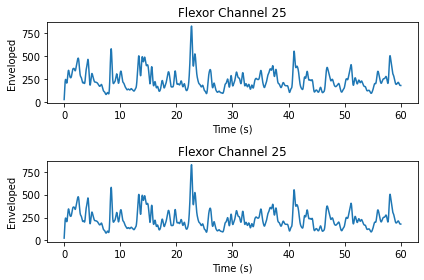

In [ ]:
# pick one flexor channel
ch = flexors[0]
col_idx = order.index(ch)

# take first 2.5 s = 5000 samples at 2 kHz
n_samples = int(60 * fs)
raw_sig = data[:n_samples, col_idx]

# get bandpassed + envelope
emg_env, emg_bp = emg_envelope(
    raw_sig,
    fs=fs,
    lowcut=lowcut,
    highcut=highcut,
    envelopecut=envelopecut,
    order=4
)

t = np.arange(n_samples) / fs # time axis in seconds

# --- plot raw vs envelope ---
ax = plt.subplot(2, 1, 1)
ax.plot(t, emg_env)
ax.set_title(f'Flexor Channel {ch}')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Enveloped')


plt.tight_layout()
plt.show()

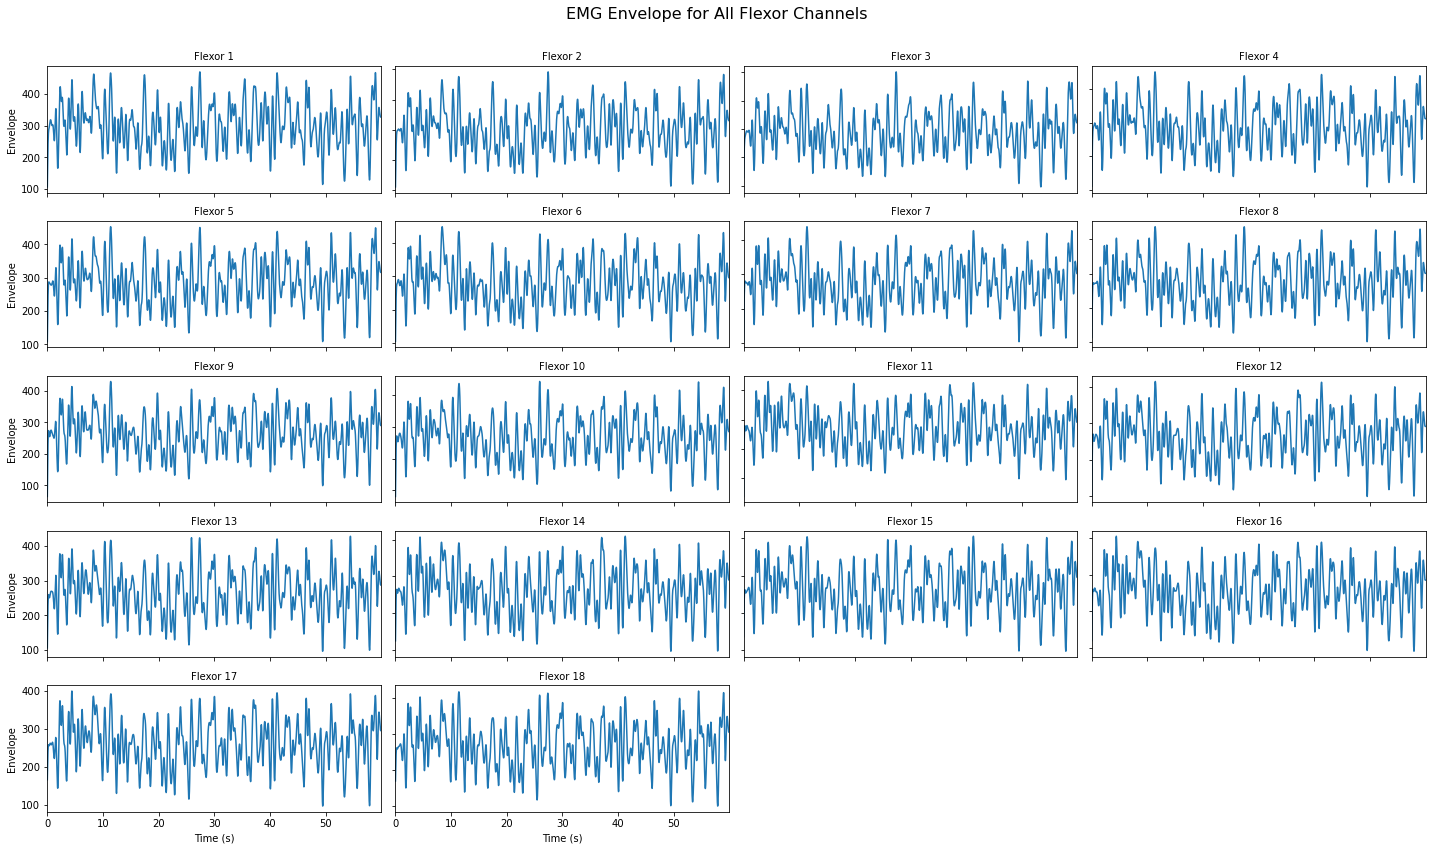

In [11]:
# --- parameters ---
n_samples = int(60 * fs)   # 60 seconds
t = np.arange(n_samples) / fs

# original channel numbers
flexors = [25,26,27,28,29,30,31,32,17,18,19,20,21,22,23,24,9,10]

# new human-readable labels for plotting
flexor_labels = list(range(1, 19))  # 1–18

# number of flexor channels
N = len(flexors)

# define grid size (square-ish)
rows = ceil(sqrt(N))
cols = ceil(N / rows)

plt.figure(figsize=(20, 12))

for i, ch in enumerate(flexors):
    label = i+1
    col_idx = order.index(ch)
    raw_sig = data[:n_samples, col_idx]

    emg_env, emg_bp = emg_envelope(
        raw_sig,
        fs=fs,
        lowcut=lowcut,
        highcut=highcut,
        envelopecut=envelopecut,
        order=4
    )

    ax = plt.subplot(rows, cols, i + 1)
    ax.plot(t, emg_env)
    ax.set_title(f"Flexor {label}", fontsize=10)
    ax.set_xlim([0, t[-1]])

    # Keep y-labels only on left column
    if i % cols == 0:
        ax.set_ylabel("Envelope")
    else:
        ax.set_yticklabels([])

    # Only bottom row gets x-labels
    if i // cols == rows - 1:
        ax.set_xlabel("Time (s)")
    else:
        ax.set_xticklabels([])

plt.suptitle("EMG Envelope for All Flexor Channels", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()



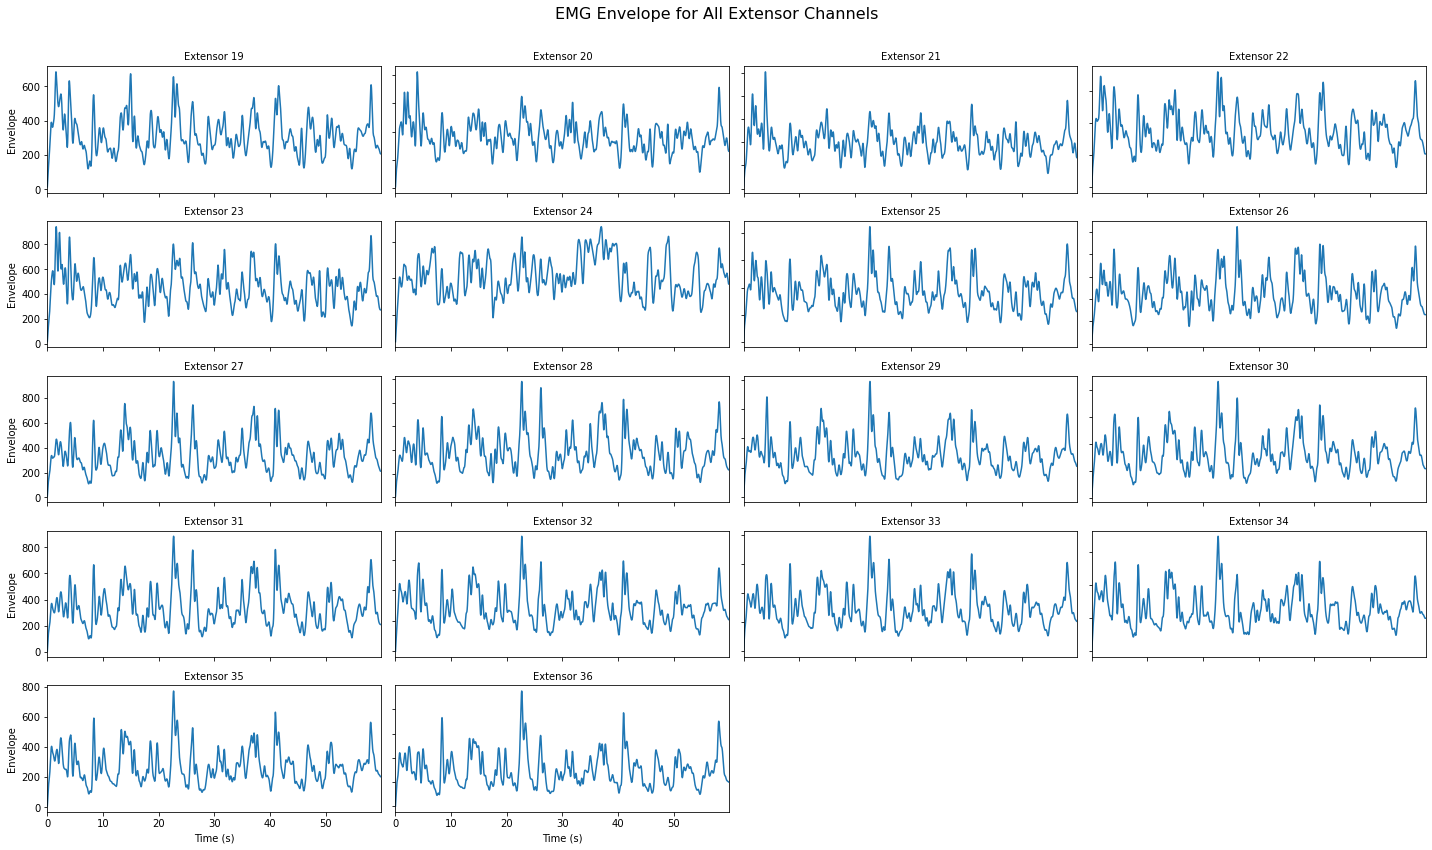

In [77]:
#extensors for segmentation for tapes
# --- parameters ---
n_samples = int(60 * fs)   # 60 seconds
t = np.arange(n_samples) / fs

# original channel numbers
extensors = [11,12,13,14,15,16,1,2,3,4,5,6,7,52,8,49,50,51] #18 ch

# new human-readable labels for plotting
flexor_labels = list(range(20, 39))  # 1–18

# number of flexor channels
N = len(flexors)

# define grid size (square-ish)
rows = ceil(sqrt(N))
cols = ceil(N / rows)

plt.figure(figsize=(20, 12))

for i, ch in enumerate(extensors):
    label = i+19
    col_idx = order.index(ch)
    raw_sig = data[:n_samples, col_idx]

    emg_env, emg_bp = emg_envelope(
        raw_sig,
        fs=fs,
        lowcut=lowcut,
        highcut=highcut,
        envelopecut=envelopecut,
        order=4
    )

    ax = plt.subplot(rows, cols, i + 1)
    ax.plot(t, emg_env)
    ax.set_title(f"Extensor {label}", fontsize=10)
    ax.set_xlim([0, t[-1]])

    # Keep y-labels only on left column
    if i % cols == 0:
        ax.set_ylabel("Envelope")
    else:
        ax.set_yticklabels([])

    # Only bottom row gets x-labels
    if i // cols == rows - 1:
        ax.set_xlabel("Time (s)")
    else:
        ax.set_xticklabels([])

plt.suptitle("EMG Envelope for All Extensor Channels", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()



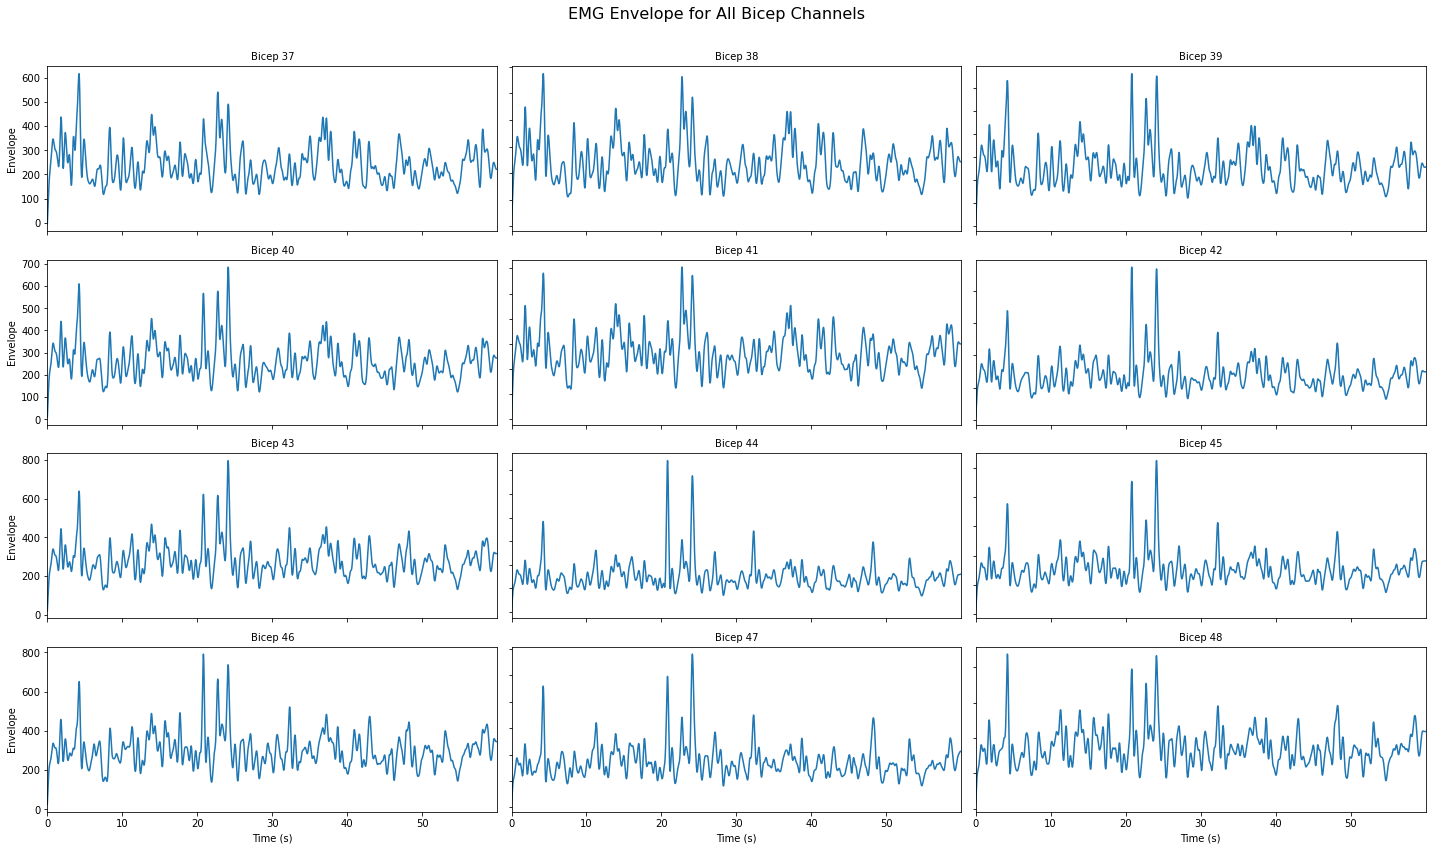

In [84]:


#bicep segmentation for tapes
# --- parameters ---
n_samples = int(60 * fs)   # 60 seconds
t = np.arange(n_samples) / fs

# original channel numbers
bicep = [40,39,38,37,36,35,34,33,48,47,46,45] # 12 ch

# new human-readable labels for plotting
ch_labels = list(range(38, 50))  # 

# number of flexor channels
N = len(bicep)

# define grid size (square-ish)
rows = ceil(sqrt(N))
cols = ceil(N / rows)

plt.figure(figsize=(20, 12))

for i, ch in enumerate(bicep):
    label = i + 37
    col_idx = order.index(ch)
    raw_sig = data[:n_samples, col_idx]

    emg_env, emg_bp = emg_envelope(
        raw_sig,
        fs=fs,
        lowcut=lowcut,
        highcut=highcut,
        envelopecut=envelopecut,
        order=4
    )

    ax = plt.subplot(rows, cols, i + 1)
    ax.plot(t, emg_env)
    ax.set_title(f"Bicep {label}", fontsize=10)
    ax.set_xlim([0, t[-1]])

    # Keep y-labels only on left column
    if i % cols == 0:
        ax.set_ylabel("Envelope")
    else:
        ax.set_yticklabels([])

    # Only bottom row gets x-labels
    if i // cols == rows - 1:
        ax.set_xlabel("Time (s)")
    else:
        ax.set_xticklabels([])

plt.suptitle("EMG Envelope for All Bicep Channels", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()



In [85]:
tricep = [42,43,41,56,47,55,54,53,62,63,64,60,61,57,58,59]
len(tricep)

16

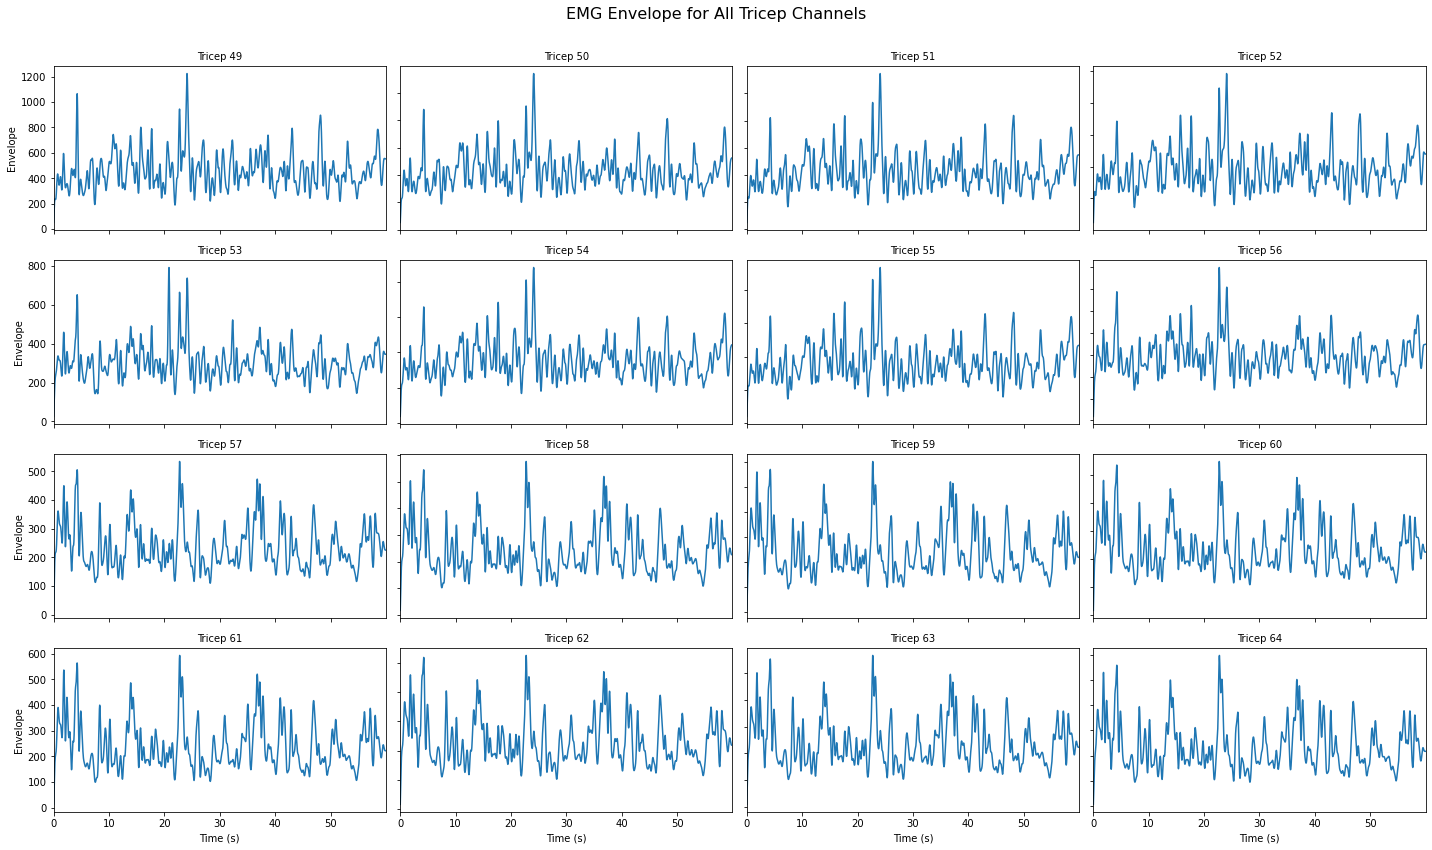

In [87]:
#lateral_tri = [42,43,41,56,47,55,54,53]
#long_tri = [62,63,64,60,61,57,58,59]


#tricep segmentation for tapes
# --- parameters ---
n_samples = int(60 * fs)   # 60 seconds
t = np.arange(n_samples) / fs

# original channel numbers
tricep = [42,43,41,56,47,55,54,53,62,63,64,60,61,57,58,59] #16 ch

# new human-readable labels for plotting
ch_labels = list(range(49, 66))  # 

# number of flexor channels
N = len(tricep)

# define grid size (square-ish)
rows = ceil(sqrt(N))
cols = ceil(N / rows)

plt.figure(figsize=(20, 12))

for i, ch in enumerate(tricep):
    label = i + 49
    col_idx = order.index(ch)
    raw_sig = data[:n_samples, col_idx]

    emg_env, emg_bp = emg_envelope(
        raw_sig,
        fs=fs,
        lowcut=lowcut,
        highcut=highcut,
        envelopecut=envelopecut,
        order=4
    )

    ax = plt.subplot(rows, cols, i + 1)
    ax.plot(t, emg_env)
    ax.set_title(f"Tricep {label}", fontsize=10)
    ax.set_xlim([0, t[-1]])

    # Keep y-labels only on left column
    if i % cols == 0:
        ax.set_ylabel("Envelope")
    else:
        ax.set_yticklabels([])

    # Only bottom row gets x-labels
    if i // cols == rows - 1:
        ax.set_xlabel("Time (s)")
    else:
        ax.set_xticklabels([])

plt.suptitle("EMG Envelope for All Tricep Channels", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()



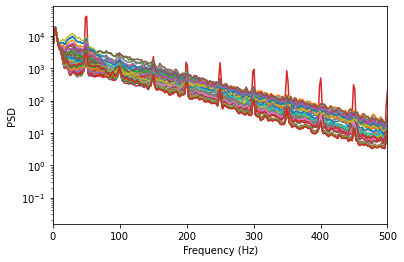

In [7]:
fs = 2000  # Hz
for i in range(64):
    f, Pxx = welch(data[:, i], fs=fs, nperseg=1024)
    plt.semilogy(f, Pxx)
    plt.xlim([0, 500])
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.show()

In [10]:
filtered_x = np.zeros_like(data)
for i in range(64):
    x_data = data[:, i]
    x_data = butter_highpass(x_data, highpass_filt, 2000) # 10 Hz highpass
    x_data = butter_lowpass(x_data, lowpass_filt, 2000) # 450 Hz lowpass 
    x_data = remove_harmonics(x_data,2000)
    filtered_x[:,i] = x_data

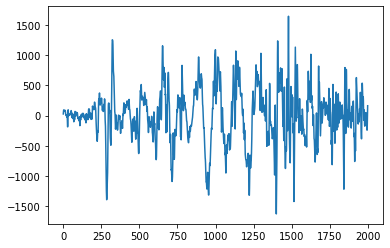

In [11]:
import matplotlib.pyplot as plt
plt.plot(filtered_x[:2000, 0])  # first channel, first 2000 samples
plt.show()